<center> <h1> Default Prediction Project </h1> </center>
<center> <h2> Give Me Some Credit </h2> </center>
<center> <i>  Tianhui Hu </i> </center>

# Exploratory Data Analysis - Preparing for one of the top performing models

In this notebook, an exploratory data analysis is performed on Give Me Some Credit's training set and preprocessing steps will be listed. These preprocessing steps will be the preparatory work for training a XGBoost model on the dataset, which is able to attain private and public scores of **0.86756** and **0.86104** respectively. The private and public scores are ranked top 100 and top 130 respectively (at the point of time of submitting this notebook).





## EDA Summary<a class="anchor" id="3"></a>
- Around 6% of samples defaulted
- MonthlyIncome and NumberOfDependents have 29731 (19.82%) and 3924 (2.61%) null values respectively
- We also notice that when NumberOfTimes90DaysLate has values above 17, there are 267 instances where the three columns NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse share the same values, specifically 96 and 98.
    - We can see that sharing the same values of 96 and 98 respectively is not logical since trivial calculations can reveal that being 30 days past due for 96 times for a single person within a timespan of 2 years is not possible.
- RevolvingUtilizationOfUnsecuredLines
    - Defined as ratio of the total amount of money owed to total credit limit
    - distribution of values is right-skewed, consider removing outliers
    - It is expected that as this value increases, the proportion of people defaulting should increase as well
    - However, we can see that as the minimum value of this column is set to 13, the proportion of defaulters is smaller than that belonging to the pool of clients with total amount of money owed not exceeding total credit limit.
    - Thus we should remove those samples with RevolvingUtilizationOfUnsecuredLines's value more than equal to 13
- age
    - There seems to be more younger people defaulting and the distribution seems fine on the whole
- NumberOfTimes90DaysLate
    - It is interesting to note that there are no one who is 90 or more days past due between 17 and 96 times.
- NumberOfTime60-89DaysPastDueNotWorse
    - It is interesting to note that there are no one who is 60-89 days past due between 11 and 96 times.
- NumberOfTime30-59DaysPastDueNotWorse
    - It is interesting to note that there are no one who is 30-59 days past due between 13 and 96 times.
- DebtRatio
    - 2.5% of clients owe around 3490 or more times what they own
    - For the people who have monthly income in this 2.5%, only 185 people have values for their monthly incomes and the values are either 0 or 1.
    - There are 164 out of these 185 people who are of two different types, first with no monthly income and does not default and second with monthly income and does default.
- MonthlyIncome
    - Distribution of values is skewed, we can consider imputation with median.
    - We can also consider imputing with normally distributed values with its mean and standard deviation.
- Numberof Dependents
    - We can consider imputing with its mode, which is zero.


## Table of Contents

1. [Import Packages](#1)
2. [Import Data](#2)
3. [EDA](#3)
   - [SeriousDlqin2yrs](#3.1)
   - [Null Values and Proportions](#3.2)
   - [MonthlyIncome](#3.3)
   - [Age](#3.4)
   - [DebtRatio](#3.5)
   - [Late Payment Columns](#3.6)
   - [NumberOfOpenCreditLinesAndLoans](#3.7)
   - [NumberRealEstateLoansOrLines](#3.8)
   - [RevolvingUtilizationOfUnsecuredLines](#3.9)
   - [NumberOfDependents](#3.10)
   - [EDA Summary](#3.11)
4. [Preprocessing Suggestions](#4)
5. [References](#5)

## Import Packages <a class="anchor" id="1"></a>

In [260]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os


## Import Data <a class="anchor" id="2"></a>

In [261]:
##df = pd.read_csv("cs-training.csv")
df_train = pd.read_csv("cs-training.csv")
df_test = pd.read_csv("cs-test.csv")
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.77,45,2,0.80,"9,120.00",13,0,6,0,2.00
1,2,0,0.96,40,0,0.12,"2,600.00",4,0,0,0,1.00
2,3,0,0.66,38,1,0.09,"3,042.00",2,1,0,0,0.00
3,4,0,0.23,30,0,0.04,"3,300.00",5,0,0,0,0.00
4,5,0,0.91,49,1,0.02,"63,588.00",7,0,1,0,0.00


Variable Name	Description	Type
- ``SeriousDlqin2yrs``	Person experienced 90 days past due delinquency or worse	Y/N
- ``RevolvingUtilizationOfUnsecuredLines``	Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits	percentage
- ``age``	Age of borrower in years	integer
- ``DebtRatio``	Monthly debt payments, alimony,living costs divided by monthy gross income	percentage
- ``MonthlyIncome``	Monthly income	real
- ``NumberOfOpenCreditLinesAndLoans``	Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)	integer
- ``NumberOfTime3059DaysPastDueNotWorse``	Number of times borrower has been 30-59 days past due but no worse in the last 2 years.	integer
- ``NumberOfTimes90DaysLate``	Number of times borrower has been 90 days or more past due.	integer
- ``NumberOfTime60-89DaysPastDueNotWorse``	Number of times borrower has been 60-89 days past due but no worse in the last 2 years.	integer
- ``NumberRealEstateLoansOrLines``	Number of mortgage and real estate loans including home equity lines of credit	integer
- ``NumberOfDependents``	Number of dependents in family excluding themselves (spouse, children etc.)	integer

In [262]:
df_train.shape

(150000, 12)

In [263]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

It's generally a good practice to remove duplicates from your data before creating a model. Duplicates can artificially inflate the size of your dataset and can also cause issues with certain types of models. Additionally, duplicates may indicate errors or inconsistencies in the data collection process that could affect the accuracy and reliability of your model. Removing duplicates ensures that each observation in your dataset is unique and reduces the risk of bias or overfitting in your model.

In [264]:
duplicates = df_train[df_train.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [Unnamed: 0, SeriousDlqin2yrs, RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30-59DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents]
Index: []


After checking, there is no duplication in the dataset, we are good to go :)

In [265]:
df_train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,"150,000.00","150,000.00","150,000.00","150,000.00","150,000.00","150,000.00","120,269.00","150,000.00","150,000.00","150,000.00","150,000.00","146,076.00"
mean,"75,000.50",0.07,6.05,52.30,0.42,353.01,"6,670.22",8.45,0.27,1.02,0.24,0.76
std,"43,301.41",0.25,249.76,14.77,4.19,"2,037.82","14,384.67",5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"37,500.75",0.00,0.03,41.00,0.00,0.18,"3,400.00",5.00,0.00,0.00,0.00,0.00
50%,"75,000.50",0.00,0.15,52.00,0.00,0.37,"5,400.00",8.00,0.00,1.00,0.00,0.00
75%,"112,500.25",0.00,0.56,63.00,0.00,0.87,"8,249.00",11.00,0.00,2.00,0.00,1.00
max,"150,000.00",1.00,"50,708.00",109.00,98.00,"329,664.00","3,008,750.00",58.00,98.00,54.00,98.00,20.00


In [266]:
## drop id column which doesn't provide any valuable info
df_train= df_train.drop("Unnamed: 0", axis=1)

In [267]:
df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.77,45,2,0.80,"9,120.00",13,0,6,0,2.00
1,0,0.96,40,0,0.12,"2,600.00",4,0,0,0,1.00
2,0,0.66,38,1,0.09,"3,042.00",2,1,0,0,0.00
3,0,0.23,30,0,0.04,"3,300.00",5,0,0,0,0.00
4,0,0.91,49,1,0.02,"63,588.00",7,0,1,0,0.00


## EDA<a class="anchor" id="3"></a>


### Feature Importance¶


In [ ]:
train_X = df_train.drop(["SeriousDlqin2yrs"], axis=1)
train_y = np.log1p(train["SeriousDlqin2yrs"].values)

In [ ]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plotando as importâncias ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features, n):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,n,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,n,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

### Derive Balance of Classes
Firstly, We also want to know how balanced the data set is, so we check what portion defaulted:

### SeriousDlqin2yrs<a class="anchor" id="3.1"></a>

<!-- ### SeriousDlqin2yrs <a class="anchor" id="3.1"></a> -->

In [196]:
df_train.SeriousDlqin2yrs.mean()

0.06684

Around 6% of samples defaulted

#### Visualize Balance of Classes

Proportion of People Who Defaulted: 0.06684


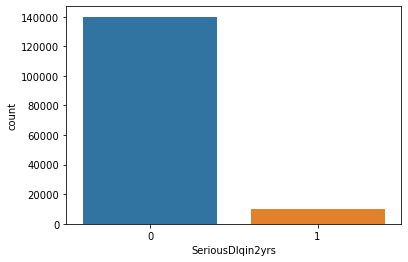

In [197]:
sns.countplot(x="SeriousDlqin2yrs", data=df)
print("Proportion of People Who Defaulted: {}".format(df["SeriousDlqin2yrs"].sum() / len(df)))

### Null Values and Proportions


In [198]:
null_val_sums = df.isnull().sum()
null_val_sums


Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

- From the avove we found there are null values in MonthlyIncome and NumberOfDependents

In [199]:
# Calculate the percentage of null values in the column of MonthlyIncome
null_percentage_MonthlyIncome = df['MonthlyIncome'].isnull().mean() * 100
null_percentage_NumberOfDependents = df['NumberOfDependents'].isnull().mean() * 100
# Print the percentage of null values
print(f'Percentage of null values in "MonthlyIncome": {null_percentage_MonthlyIncome:.2f}%')
print(f'Percentage of null values in "NumberOfDependents": {null_percentage_NumberOfDependents:.2f}%')



Percentage of null values in "MonthlyIncome": 19.82%
Percentage of null values in "NumberOfDependents": 2.62%


In [200]:
null_val_sums = df.isnull().sum()
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df) })


,Column,Number of Null Values,Proportion
0,Unnamed: 0,0,0.00
1,SeriousDlqin2yrs,0,0.00
2,RevolvingUtilizationOfUnsecuredLines,0,0.00
3,age,0,0.00
4,NumberOfTime30-59DaysPastDueNotWorse,0,0.00
5,DebtRatio,0,0.00
6,MonthlyIncome,29731,0.20
7,NumberOfOpenCreditLinesAndLoans,0,0.00
8,NumberOfTimes90DaysLate,0,0.00
9,NumberRealEstateLoansOrLines,0,0.00


### MonthlyIncome<a class="anchor" id="3.3"></a>

In [201]:
# Set the format string to display numbers with a comma separator
# and without scientific notation
format_str = lambda x: '{:,.2f}'.format(x)

# Set the float format for the MonthlyIncome column
pd.options.display.float_format = format_str
desc = df['MonthlyIncome'].describe()

# Display the output
print(desc)


count     120,269.00
mean        6,670.22
std        14,384.67
min             0.00
25%         3,400.00
50%         5,400.00
75%         8,249.00
max     3,008,750.00
Name: MonthlyIncome, dtype: float64


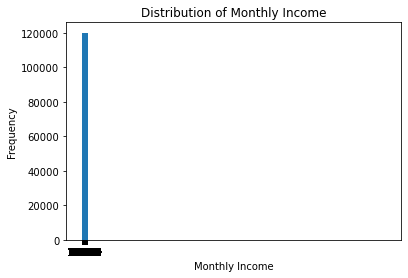

In [202]:
# Plot the distribution of monthly income
df['MonthlyIncome'].dropna().plot.hist(bins=50)
plt.title('Distribution of Monthly Income')
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
# Set the x-axis tick labels to be in thousands of dollars
plt.xticks(range(0, 50000, 5))
plt.show()



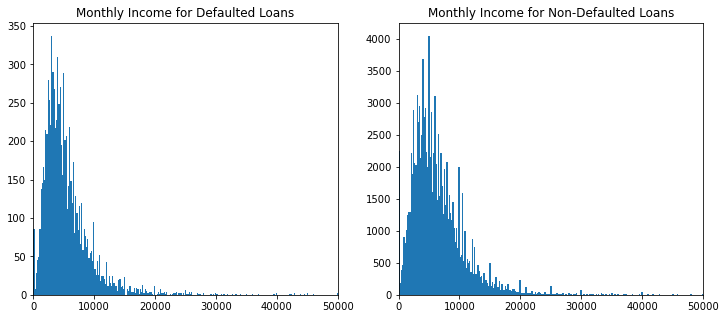

In [203]:
monthlyincome = df['MonthlyIncome'].dropna()
n = len(monthlyincome)
iqr = np.percentile(monthlyincome, 75) - np.percentile(monthlyincome, 25)
bin_size = 2 * iqr / (n ** (1/3))

# Create histograms for defaulted and non-defaulted loans
defaulted = df[df['SeriousDlqin2yrs'] == 1]['MonthlyIncome'].dropna()
non_defaulted = df[df['SeriousDlqin2yrs'] == 0]['MonthlyIncome'].dropna()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(defaulted, bins=np.arange(0, monthlyincome.max()+bin_size, bin_size),label='Defaulted')
ax1.set_title('Monthly Income for Defaulted Loans')
ax1.set_xlim(0, 50000)

ax2.hist(non_defaulted, bins=np.arange(0, monthlyincome.max()+bin_size, bin_size), label='Non-Defaulted')
ax2.set_title('Monthly Income for Non-Defaulted Loans')
ax2.set_xlim(0, 50000)


plt.show()


In [204]:
defaulted.describe()


count     8,357.00
mean      5,630.83
std       6,171.72
min           0.00
25%       2,963.00
50%       4,500.00
75%       6,800.00
max     250,000.00
Name: MonthlyIncome, dtype: float64

In [205]:
non_defaulted.describe()


count     111,912.00
mean        6,747.84
std        14,813.50
min             0.00
25%         3,461.00
50%         5,466.00
75%         8,333.00
max     3,008,750.00
Name: MonthlyIncome, dtype: float64

**From the two graphs and the statistics provided, we can observe the following:**

Defaulted loans: The distribution of monthly income for defaulted loans is positively skewed with a mean of 5,630.83 and a median of 4,500. The standard deviation is relatively high at 6,171.72, indicating that the data points are more dispersed. Additionally, the maximum value is 250,000, which is a significant outlier in the distribution. Overall, this suggests that borrowers with lower monthly incomes are more likely to default on their loans.

Non-defaulted loans: The distribution of monthly income for non-defaulted loans appears to be relatively normally distributed, with a mean of 6,747.84 and a median of 5,466. The standard deviation is higher than that of the defaulted loans at 14,813.50, indicating that the data points are more dispersed. Additionally, the maximum value is also an outlier at 3,008,750. 

Overall, this suggests that borrowers with lower monthly incomes are more likely to default on their loans. Lenders may want to take this into account when assessing the creditworthiness of potential borrowers and setting interest rates. Additionally, borrowers with lower incomes may benefit from financial education and assistance to help them manage their debt and improve their creditworthiness.

### age<a class="anchor" id="3.4"></a>

In [206]:
df_train.age.describe()

count   150,000.00
mean         52.30
std          14.77
min           0.00
25%          41.00
50%          52.00
75%          63.00
max         109.00
Name: age, dtype: float64

#### "If you're over 55 and need a mortgage, the important thing to know if that lenders can't deny you a loan based on your age. But age can factor into your mortgage equation." ([Source](https://www.chicagotribune.com/news/ct-xpm-2005-11-20-0511200488-story.html))

This should be our first concern: making sure the lender cannot deny an elderly person a loan or charge them more because they are old, according to the Equal Opportunity Credit Act, which prohibits lender discrimination for various protected categories, including the borrower's age.

Therefore, we need to confirm that in our data set age has a negative influence on probability of defaulting. Then we can assume that the models we build reflect that trend, and won't deny someone a loan simply because they are old. 

Text(0.5, 1.0, 'SeriousDlqin2yrs = 1')

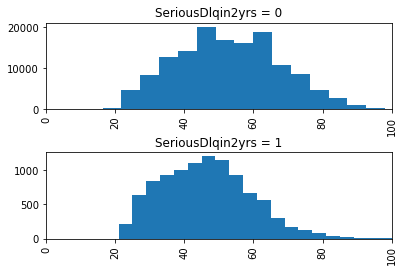

In [207]:
age_hist = df['age'].hist(by=df['SeriousDlqin2yrs'], bins=20, layout=(2,1))
age_hist[0].set_xlim((0,100))
age_hist[0].set_title('SeriousDlqin2yrs = 0')
age_hist[1].set_xlim((0,100))
age_hist[1].set_title('SeriousDlqin2yrs = 1')

There seems to be more younger people defaulting and the distribution seems fine on the whole. So we are good to go !

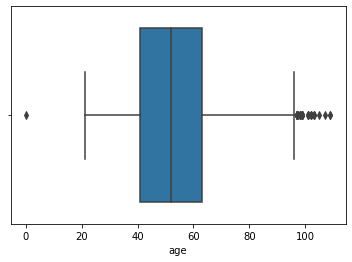

In [208]:
sns.boxplot(df_train['age'])

And there is one data point has 0 for age, that's not possible, but given just one data point, it's ok not to remove it, as it might provided other valuable information for other metrics.

### DebtRatio<a class="anchor" id="3.5"></a>

In [209]:
df_train.DebtRatio.describe()

count   150,000.00
mean        353.01
std       2,037.82
min           0.00
25%           0.18
50%           0.37
75%           0.87
max     329,664.00
Name: DebtRatio, dtype: float64

The fact that a person owes 330,000 times more than what they own is quite alarming. It raises the question of whether this individual is an outlier or not. To confirm this, let's investigate further:

In [210]:
df_train.DebtRatio.quantile([.975])

0.97   3,489.02
Name: DebtRatio, dtype: float64

It appears that a small fraction (2.5%) of the dataset owes a significantly higher amount (over 3,500 times) than what they own. Further investigation is required to determine whether these data points are outliers or not. As observed, this subset of data stands out from the rest.

In [211]:
df_train[df_train['DebtRatio'] > 3489.025][['SeriousDlqin2yrs','MonthlyIncome','DebtRatio']].describe()

,SeriousDlqin2yrs,MonthlyIncome,DebtRatio
count,"3,750.00",185.00,"3,750.00"
mean,0.06,0.06,"5,917.49"
std,0.25,0.25,"10,925.52"
min,0.00,0.00,"3,490.00"
25%,0.00,0.00,"3,957.25"
50%,0.00,0.00,"4,619.00"
75%,0.00,0.00,"5,789.50"
max,1.00,1.00,"329,664.00"


Two alarming observations can be made from the data. 

- Out of the 4,000 records with a DebtRatio greater than 3,500, only 185 have a recorded value for their monthly income. 

- Those who do have a monthly income seem to have a fixed value of either 1 or 0.


In [212]:
len(df_train[(df_train["DebtRatio"] > 3489.025 ) & (df_train['SeriousDlqin2yrs'] == df['MonthlyIncome'])])

164

In [213]:
print("Number of people who owe around 3490 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: {}"\
     .format(len(df_train.loc[(df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.975)) & (df_train["MonthlyIncome"] == df_train["SeriousDlqin2yrs"])])))

Number of people who owe around 3490 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: 164


<!-- ..of those 185 entries, 164 of them have the same value for Person experienced 90 days past due delinquency or worse  in last two years and monthly income, indicating that there is a data-entry error, which mighted be caused due to data copied from SeriousDlqin2yrs to monthlyIncome. 

The second problem is that despite owing thousands of times what they own, these people aren't defaulting any more than the general population, as the mean value for SeriousDlqin2yrs for those records is very closed to population default rate. We can conclude that these entries must be data-entry errors, **so we will remove them from our model.** -->
There are two important observations worthwhile mentioning from the above statistic: 

- 1.Out of the 185 entries, 164 of them show the same value for both the Person Experienced 90 Days Past Due Delinquency or Worse in Last Two Years and Monthly Income. This suggests that there may be a data-entry error, possibly caused by copying data from the SeriousDlqin2yrs column into the monthlyIncome column.  


- 2.Small fraction of the dataset owes significantly more than what they own, but they are not defaulting any more than the general population. This is evident from the mean value for SeriousDlqin2yrs being similar to the population default rate. While it is tempting to remove these entries, it is important to investigate whether they are truly outliers or not before making any changes to the model. Therefore, Thus, we can infer that these entries are erroneous and should be removed from the model

<!-- --Thus, we can infer that these entries are erroneous and should be removed from the model. -->




As 164 is a small portition for the whole population (150000), so I will remove these outliners after EDA step.

### Late Payment Columns<a class="anchor" id="3.7"></a>
- NumberOfTimes90DaysLate
- NumberOfTime60-89DaysPastDueNotWorse
- NumberOfTime30-59DaysPastDueNotWorse

#### NumberOfTimes90DaysLate

In [214]:
late_pay_cols = ["NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTime30-59DaysPastDueNotWorse"]
df_train["NumberOfTimes90DaysLate"].value_counts().sort_index()

0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

In [215]:
bins = list(range(0, 18)) + [96, 98, 99]
labels = bins.copy()
labels.pop()
df_90dayslate = df.groupby(pd.cut(df["NumberOfTimes90DaysLate"], bins=bins, labels=labels)).agg({"SeriousDlqin2yrs": ["count", "mean"]})
df_90dayslate.columns = ["_".join(x) for x in df_90dayslate.columns.ravel()]
df_90dayslate = df_90dayslate.reset_index()
df_90dayslate.columns = ["NumberOfTimes90DaysLate", "count", "default_rate"]

print(df_90dayslate)

# plt.bar(df_90dayslate["NumberOfTimes90DaysLate"], df_90dayslate["default_rate"])
# plt.title("Default rate by number of times 90 days or more past due")
# plt.xlabel("Number of times 90 days or more past due")
# plt.ylabel("Default rate")
# plt.show()


   NumberOfTimes90DaysLate  count  default_rate
0                        0   5243          0.34
1                        1   1555          0.50
2                        2    667          0.58
3                        3    291          0.67
4                        4    131          0.63
5                        5     80          0.60
6                        6     38          0.82
7                        7     21          0.71
8                        8     19          0.74
9                        9      8          0.62
10                      10      5          0.60
11                      11      2          0.50
12                      12      4          0.50
13                      13      2          0.50
14                      14      2          0.00
15                      15      0           nan
16                      16      1          1.00
17                      17      5          0.80
18                      96    264          0.54
19                      98      0       

#### NumberOfTime60-89DaysPastDueNotWorse

In [216]:
df_train["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()

0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [217]:
bins = list(range(0, 10)) + [11, 96, 98]
labels = bins.copy()
labels.pop()

df_60_89dayslate = df.groupby(pd.cut(df["NumberOfTime60-89DaysPastDueNotWorse"], bins=bins, labels=labels)).agg({"SeriousDlqin2yrs": ["count", "mean"]})
df_60_89dayslate.columns = ["_".join(x) for x in df_60_89dayslate.columns.ravel()]
df_60_89dayslate = df_60_89dayslate.reset_index()
df_60_89dayslate.columns = ["NumberOfTime60-89DaysPastDueNotWorse", "count", "default_rate"]

print(df_60_89dayslate)

   NumberOfTime60-89DaysPastDueNotWorse  count  default_rate
0                                     0   5731          0.31
1                                     1   1118          0.50
2                                     2    318          0.57
3                                     3    105          0.62
4                                     4     34          0.62
5                                     5     16          0.75
6                                     6      9          0.56
7                                     7      2          0.50
8                                     8      1          0.00
9                                     9      1          1.00
10                                   11      5          0.80
11                                   96    264          0.54


#### NumberOfTime30-59DaysPastDueNotWorse

In [218]:
df_train["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

0     126018
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       264
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

In [219]:
bins = list(range(0, 14)) + [96, 98]
labels = bins.copy()
labels.pop()
df_30_59dayslate = df.groupby(pd.cut(df["NumberOfTime30-59DaysPastDueNotWorse"], bins=bins, labels=labels)).agg({"SeriousDlqin2yrs": ["count", "mean"]})
df_30_59dayslate.columns = ["_".join(x) for x in df_30_59dayslate.columns.ravel()]
df_30_59dayslate = df_30_59dayslate.reset_index()
df_30_59dayslate.columns = ["NumberOfTime30-59DaysPastDueNotWorse", "count", "default_rate"]
print(df_30_59dayslate)

   NumberOfTime30-59DaysPastDueNotWorse  count  default_rate
0                                     0  16033          0.15
1                                     1   4598          0.27
2                                     2   1754          0.35
3                                     3    747          0.43
4                                     4    342          0.45
5                                     5    140          0.53
6                                     6     54          0.52
7                                     7     25          0.32
8                                     8     12          0.33
9                                     9      4          0.75
10                                   10      1          1.00
11                                   11      2          0.50
12                                   12      1          1.00
13                                   13      5          0.80
14                                   96    264          0.54


####  NumberOfTimes90DaysLate

In [220]:
df_train.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count()

NumberOfTimes90DaysLate
0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

It's obvious to get the observation that majority of person (94.4%)do not have previous experience with delayed payment has been 90 days or more past due. 

There are no individuals who have been late between 17 and 96 times, but there are several hundred people who have been late 98 times. We can examine these few hundred entries.


In [221]:
df_train[df_train['NumberOfTimes90DaysLate'] > 96][['SeriousDlqin2yrs','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate']].describe()

,SeriousDlqin2yrs,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,264.00,264.00,264.00,264.00
mean,0.54,98.00,98.00,98.00
std,0.50,0.00,0.00,0.00
min,0.00,98.00,98.00,98.00
25%,0.00,98.00,98.00,98.00
50%,1.00,98.00,98.00,98.00
75%,1.00,98.00,98.00,98.00
max,1.00,98.00,98.00,98.00


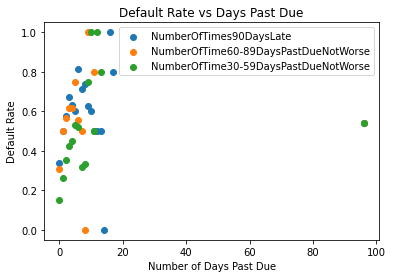

In [222]:
# scatter plot for NumberOfTimes90DaysLate
plt.scatter(df_90dayslate["NumberOfTimes90DaysLate"], df_90dayslate["default_rate"], label="NumberOfTimes90DaysLate")

# scatter plot for NumberOfTime60-89DaysPastDueNotWorse
plt.scatter(df_60_89dayslate["NumberOfTime60-89DaysPastDueNotWorse"], df_60_89dayslate["default_rate"], label="NumberOfTime60-89DaysPastDueNotWorse")

# scatter plot for NumberOfTime30-59DaysPastDueNotWorse
plt.scatter(df_30_59dayslate["NumberOfTime30-59DaysPastDueNotWorse"], df_30_59dayslate["default_rate"], label="NumberOfTime30-59DaysPastDueNotWorse")

# set x-axis label
plt.xlabel("Number of Days Past Due")

# set y-axis label
plt.ylabel("Default Rate")

# set title
plt.title("Default Rate vs Days Past Due")

# add legend
plt.legend()

# show plot
plt.show()

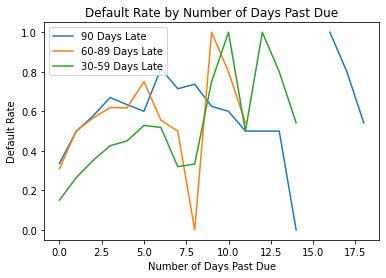

In [223]:
plt.plot(df_90dayslate["NumberOfTimes90DaysLate"], df_90dayslate["default_rate"], label="90 Days Late")
plt.plot(df_60_89dayslate["NumberOfTime60-89DaysPastDueNotWorse"], df_60_89dayslate["default_rate"], label="60-89 Days Late")
plt.plot(df_30_59dayslate["NumberOfTime30-59DaysPastDueNotWorse"], df_30_59dayslate["default_rate"], label="30-59 Days Late")
plt.xlabel("Number of Days Past Due")
plt.ylabel("Default Rate")
plt.title("Default Rate by Number of Days Past Due")
plt.legend()
plt.show()

### NumberOfOpenCreditLinesAndLoans

In [224]:
df_train["NumberOfOpenCreditLinesAndLoans"].describe()

count   150,000.00
mean          8.45
std           5.15
min           0.00
25%           5.00
50%           8.00
75%          11.00
max          58.00
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [225]:
df_train["NumberOfOpenCreditLinesAndLoans"].value_counts().sort_index()

0      1888
1      4438
2      6666
3      9058
4     11609
5     12931
6     13614
7     13245
8     12562
9     11355
10     9624
11     8321
12     7005
13     5667
14     4546
15     3645
16     3000
17     2370
18     1874
19     1433
20     1169
21      864
22      685
23      533
24      422
25      337
26      239
27      194
28      150
29      114
30       88
31       74
32       52
33       47
34       35
35       27
36       18
37        7
38       13
39        9
40       10
41        4
42        8
43        8
44        2
45        8
46        3
47        2
48        6
49        4
50        2
51        2
52        3
53        1
54        4
56        2
57        2
58        1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

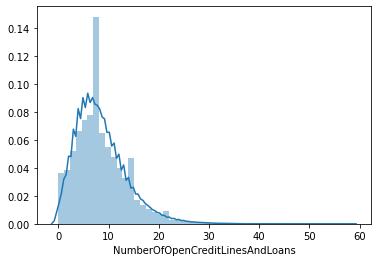

In [226]:
sns.distplot(df["NumberOfOpenCreditLinesAndLoans"])

### NumberRealEstateLoansOrLines

In [227]:
df["NumberRealEstateLoansOrLines"].describe()

count   150,000.00
mean          1.02
std           1.13
min           0.00
25%           0.00
50%           1.00
75%           2.00
max          54.00
Name: NumberRealEstateLoansOrLines, dtype: float64

In [228]:
df["NumberRealEstateLoansOrLines"].value_counts()

0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
14        7
15        7
16        4
17        4
25        3
18        2
19        2
20        2
23        2
32        1
21        1
26        1
29        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

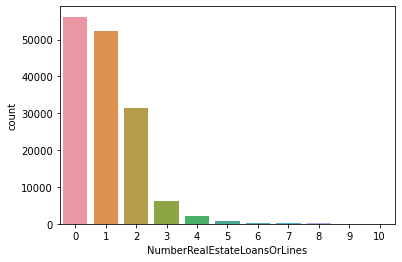

In [229]:
sns.countplot(x="NumberRealEstateLoansOrLines", data=df.loc[df["NumberRealEstateLoansOrLines"] <= 10])

In [230]:
df.loc[df["NumberRealEstateLoansOrLines"] > 13]["SeriousDlqin2yrs"].describe()

count   38.00
mean     0.21
std      0.41
min      0.00
25%      0.00
50%      0.00
75%      0.00
max      1.00
Name: SeriousDlqin2yrs, dtype: float64

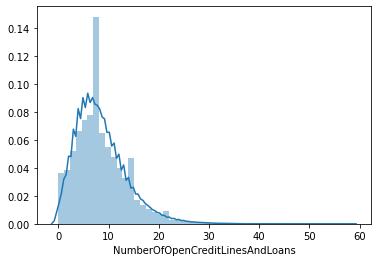

In [231]:
sns.distplot(df["NumberOfOpenCreditLinesAndLoans"])

### RevolvingUtilizationOfUnsecuredLines<a class="anchor" id="3.9"></a>

In [232]:
df_train["RevolvingUtilizationOfUnsecuredLines"].describe() 


count   150,000.00
mean          6.05
std         249.76
min           0.00
25%           0.03
50%           0.15
75%           0.56
max      50,708.00
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

This metric represents the ratio of money owed to credit limit, so it shouldn't get much above 1. First let's look at values close to 1 and see at what rate they're defaulting, so maximum up to 50708 is definitely concerning in this case. 

In [233]:
df_train["RevolvingUtilizationOfUnsecuredLines"].quantile([.90])


0.90   0.98
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [234]:
df_train[(df_train['RevolvingUtilizationOfUnsecuredLines'] > .90) & (df_train['RevolvingUtilizationOfUnsecuredLines'] <= 4)].SeriousDlqin2yrs.describe()

count   19,805.00
mean         0.23
std          0.42
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: SeriousDlqin2yrs, dtype: float64

And then we want to see what is the proportion of data that has a RevolvingUtilizationOfUnsecuredLines greater one (abnormal value)

In [235]:
df_train[(df_train['RevolvingUtilizationOfUnsecuredLines'] > 1)].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,"3,321.00","3,321.00","3,321.00","3,321.00","3,321.00","2,773.00","3,321.00","3,321.00","3,321.00","3,321.00","3,260.00"
mean,0.37,259.77,44.06,1.02,245.17,"5,289.57",6.37,0.64,0.68,0.43,0.92
std,0.48,"1,659.03",12.66,1.36,939.84,"5,134.13",4.03,1.33,0.97,0.85,1.20
min,0.00,1.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.02,34.00,0.00,0.18,"2,700.00",3.00,0.00,0.00,0.00,0.00
50%,0.00,1.07,43.00,1.00,0.37,"4,184.00",6.00,0.00,0.00,0.00,0.00
75%,1.00,1.30,52.00,2.00,0.81,"6,458.00",8.00,1.00,1.00,1.00,2.00
max,1.00,"50,708.00",88.00,10.00,"21,395.00","141,500.00",40.00,15.00,10.00,7.00,8.00


There are 3321 entries with abnormal RevolvingUtilizationOfUnsecuredLines, before making the deletion of removing these values, we would like to see how it impacts SeriousDlqin2yrs default portion.

In [236]:
df_train[(df_train['RevolvingUtilizationOfUnsecuredLines'] > 1)].groupby('SeriousDlqin2yrs').size()

SeriousDlqin2yrs
0    2084
1    1237
dtype: int64

In [237]:
df_train.groupby('SeriousDlqin2yrs').size()

SeriousDlqin2yrs
0    139974
1     10026
dtype: int64

We can observe a good amount of defaulters in these data, which taking account of 12.3% among all defaulters, if we remove these all the data would get even more imbalanced. 

In [238]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > 1) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 4)].SeriousDlqin2yrs.describe()

count   3,057.00
mean        0.40
std         0.49
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: SeriousDlqin2yrs, dtype: float64

These 3,057 people are defaulting at a rate of 40%. This is important! But what about people with more RUUL? Let's consider 4 to 10:

In [239]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > 4) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 10)].SeriousDlqin2yrs.describe()

count   23.00
mean     0.26
std      0.45
min      0.00
25%      0.00
50%      0.00
75%      0.50
max      1.00
Name: SeriousDlqin2yrs, dtype: float64

In [240]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > 4) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 10)].SeriousDlqin2yrs.describe()

count   23.00
mean     0.26
std      0.45
min      0.00
25%      0.00
50%      0.00
75%      0.50
max      1.00
Name: SeriousDlqin2yrs, dtype: float64

There are only 23 records in this region, but they're still defaulting at a high rate 26%. What about if we go even higher, and consider those with RUUL > 10?

In [241]:
df_train[(df_train['RevolvingUtilizationOfUnsecuredLines'] > 10)].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,241.00,241.00,241.00,241.00,241.00,173.00,241.00,241.00,241.00,241.00,228.00
mean,0.07,"3,564.02",50.63,0.19,571.92,"8,467.67",5.76,0.07,1.19,0.09,0.69
std,0.26,"5,123.80",14.57,0.58,"1,772.95","6,564.07",3.11,0.58,1.07,0.56,1.04
min,0.00,11.39,24.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,0.00,941.00,39.00,0.00,0.22,"4,500.00",4.00,0.00,0.00,0.00,0.00
50%,0.00,"2,012.00",48.00,0.00,0.40,"7,000.00",5.00,0.00,1.00,0.00,0.00
75%,0.00,"4,116.00",62.00,0.00,59.00,"10,091.00",7.00,0.00,2.00,0.00,1.00
max,1.00,"50,708.00",87.00,3.00,"21,395.00","44,472.00",21.00,8.00,9.00,7.00,4.00


Despite owing hundreds of thousands of times their credit limits, these 241 individuals are not defaulting more than the others. However, their data seems inconsistent with the rest of the dataset, so it would be appropriate to remove them from our model.

In [242]:
df_train_dropped= df_train.drop(df_train[(df_train['RevolvingUtilizationOfUnsecuredLines'] > 10)].index)

In [243]:
df_train_dropped.shape

(149759, 11)

### NumberOfDependents<a class="anchor" id="3.10"></a>

In [244]:
df_train["NumberOfDependents"].describe()


count   146,076.00
mean          0.76
std           1.12
min           0.00
25%           0.00
50%           0.00
75%           1.00
max          20.00
Name: NumberOfDependents, dtype: float64

In [245]:
df["NumberRealEstateLoansOrLines"].value_counts()

0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
14        7
15        7
16        4
17        4
25        3
18        2
19        2
20        2
23        2
32        1
21        1
26        1
29        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

In [246]:
df_train.loc[df_train["NumberOfDependents"] <= 10]["SeriousDlqin2yrs"].describe()

count   146,074.00
mean          0.07
std           0.25
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: SeriousDlqin2yrs, dtype: float64

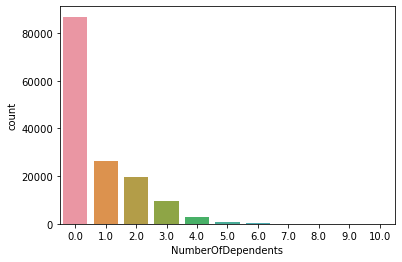

In [247]:
sns.countplot(x="NumberOfDependents", data=df_train.loc[df_train["NumberOfDependents"] <= 10])

## Preprocessing Suggestions <a class="anchor" id="4"></a>


- Remove samples with values of DebtRatio above its 97.5 percentile
- Set 0 <= RevolvingUtilizationOfUnsecuredLines < 13
- Set NumberOfTimes90DaysLate <= 17
- Impute MonthlyIncome with its median, or with a normally distributed variable with MonthlyIncome's mean and standard deviation or use linear regression to fill missing na.
- Impute NumberOfDependents with its mode